In [1]:
import PolynomialRoots.roots
using Distributions
using Plots
using PGFPlotsX
using LaTeXStrings
using Colors
using JLD
using AIDA
using ReactiveMP
using Parameters
import ProgressMeter
pgfplotsx()
# gr()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}")

1-element Vector{String}:
 "\\usepgfplotslibrary{fillbetween}"

In [2]:
@unpack AR_params, active_models, active_scenes = JLD.load("jlds/context_inference.jld")

Dict{String, Any} with 3 entries:
  "AR_params"     => Vector{Any}[[[-0.308084], 1.0, 1], [[0.721999, -0.673186],…
  "active_scenes" => Any[2, 3, 4, 1, 1, 4, 4, 4, 1, 3  …  1, 2, 4, 3, 1, 2, 1, …
  "active_models" => Any[2, 3, 4, 1, 1, 4, 4, 4, 1, 3  …  1, 2, 4, 3, 1, 2, 1, …

In [26]:
function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [170]:
using Random
Random.seed!(42)

MersenneTwister(42)

In [32]:
n_datasets = 1000
n_samples = 100
AR_params = [   [[-0.3080838230366556], 1.0, 1], 
                [[0.7219989150412909, -0.6731858297569835], 0.5, 2], 
                [[1.0313785084228675, -0.5765223505264834], 0.3, 3], 
                [[-1.4331730095408668, -0.17395999241463064, 0.7571935446137292, 0.46661005484863155], 1.0, 4]
            ]     
AR_params_seq = rand(map(x -> (length(x[1]), x[1], x[2], x[3]), AR_params), n_datasets)
orders = map(x -> length(x[1]), AR_params)
ar_data = [generateAR(n_samples, AR_params_seq[i][1], coefs=AR_params_seq[i][2], nvar=AR_params_seq[i][3]) for i in 1:n_datasets];

In [33]:
# to cure numerical instability
ar_data = filter(x -> maximum(abs.(first.(x[2]))) < 100, ar_data);

In [34]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
active_models = []
active_scenes = []
vmp_iter = 50
models = convert(AbstractArray{Any}, map(_ -> lar_inference, orders))
push!(models, inference_gaussian)
priors = map(x -> Dict(:mθ => x[1] .+ sqrt(1e-3)*randn(length(x[1])), :vθ => diageye(length(x[1])), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => x[2], :order => length(x[1])), AR_params)
push!(priors, Dict(:aτ => 1.0, :bτ => 1.0))
ProgressMeter.@showprogress for j in 1:length(ar_data)
    push!(active_scenes, AR_params_seq[j][4])
    observations = first.(ar_data[j][2])
    scene = model_selection(observations, 
                            models,
                            priors,
                            vmp_iter=vmp_iter)
    push!(active_models, scene)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:33:40


In [35]:
JLD.save("jlds/context_inference.jld", "AR_params", AR_params, "active_models", active_models, "active_scenes", active_scenes)

In [36]:
function cat_accuracy(y_pred, y_true)
    return sum(y_pred .== y_true) / length(y_true)
end

cat_accuracy (generic function with 1 method)

In [37]:
cat_accuracy(active_scenes, active_models)

0.988

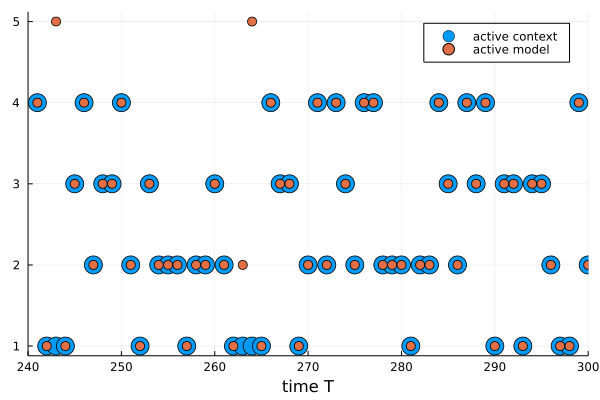

In [40]:
gr()
scatter(active_scenes, markersize=10.0, label = "active context", xlims=(240, 300))
scatter!(active_models, markersize=5.0, label = "active model", xlabel="time T")

In [42]:
pgfplotsx()
n_datasets = 100

from, to = 240, 300

axis1 = @pgf Axis({xlabel=L"t",
           ylabel="context ",
           legend_pos = "outer north east",
           legend_cell_align="{left}",
           grid = "major",
    },
    Plot(
        {only_marks,color="blue",opacity=1.0, mark_size=2.0, opacity=1.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(from:to), y = active_scenes[from:to]
        ),
    ), LegendEntry("active scenes"),
    Plot(
        {fill="black", only_marks,color="red", mark_size=1.5, opacity=1.0, mark="triangle*"},
        Table(
            {x = "x", y = "y"},
             x = collect(from:to), y = active_models[from:to]
        ),
    ), LegendEntry("active models"),)


pgfsave("tmp/contexts.pdf", axis1)
pgfsave("tikz/contexts.tikz", axis1)